In [9]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

import nibabel as nib

In [10]:
import numpy as np

from torchvision import transforms
import os
classes = ['HRP','HC']

class StructuralDataset(Dataset):
    def __init__(self,data_root,transform):
        self.samples = []
        self.transform = transform
        for label in os.listdir(data_root):
            for no in os.listdir(os.path.join(data_root,label)):
                if label=='HRP':
                    labels = 0
                else:
                    labels = 1
                img = nib.load(os.path.join(data_root,label,no))
                imgdata = img.get_fdata()
                imgdata = np.array(imgdata)
                if self.transform:
                    imgdata = self.transform(imgdata)
                image_extend = torch.empty(1,136,256,256)
                image_extend[0] = imgdata
                #image_extend = image_extend.permute(1,0,2,3)
                self.samples.append((image_extend,labels))
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self,idx):
        return self.samples[idx]
    
#normalize=transforms.Normalize(mean=[.5,.5,.5],std=[.5,.5,.5])
transform=transforms.Compose([
    transforms.ToTensor(), #将图片转换为Tensor,归一化至[0,1]
    #normalize
])


dataset = StructuralDataset('D:/strucdata',transform)
print(len(dataset))
print(dataset[2][0].shape)

28
torch.Size([1, 136, 256, 256])


In [11]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size = 3, shuffle = True, num_workers = 0)

for i, batch in enumerate(dataloader):
    print(i, batch[0].shape)

0 torch.Size([3, 1, 136, 256, 256])
1 torch.Size([3, 1, 136, 256, 256])
2 torch.Size([3, 1, 136, 256, 256])
3 torch.Size([3, 1, 136, 256, 256])
4 torch.Size([3, 1, 136, 256, 256])
5 torch.Size([3, 1, 136, 256, 256])
6 torch.Size([3, 1, 136, 256, 256])
7 torch.Size([3, 1, 136, 256, 256])
8 torch.Size([3, 1, 136, 256, 256])
9 torch.Size([1, 1, 136, 256, 256])


torch.Size([3, 1, 136, 256, 256])
torch.Size([3, 1, 256, 256])


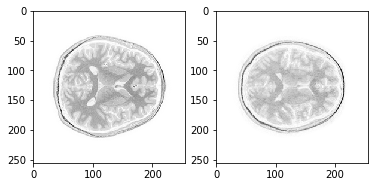

In [12]:
import torchvision
image,label = next(iter(dataloader))
print(image.shape)

image_axial = image[:,:,63,:,:]
print(image_axial.shape)
fig, axes = plt.subplots(1,2)
axes[0].imshow(image_axial[0,0,:,:],cmap='Greys')
axes[1].imshow(image_axial[1,0,:,:],cmap= 'Greys')
#plt.imshow(torchvision.utils.make_grid(image_axial))

torch.Size([3, 1, 256, 256])
(260, 776, 3)


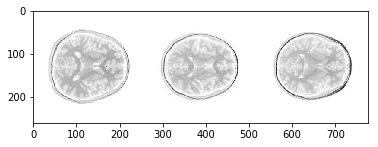

In [13]:
print(image_axial.shape)
img = torchvision.utils.make_grid(image_axial)

img = img.permute(1,2,0).numpy()
print(img.shape)

plt.imshow(img[:,:,0],cmap='Greys')

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv3d(1,3,3)
        self.pool = nn.MaxPool3d(2,2)
        self.conv2 = nn.Conv3d(3,6,3)
        self.fc1 = nn.Linear(6*62*62*32,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        self.fc4 = nn.Linear(10,2)
    
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,6*62*62*32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return x

net = Net()

In [15]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr =0.001, momentum= 0.9)

In [16]:
for epoch in range(1):
    
    running_loss = 0.00
    for i,data in enumerate(dataloader,0):
        inputs, labels = data
        
        optimizer.zero_grad()
        
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        print('loss:%.3f' % (running_loss))
        running_loss = 0

loss:5.761
loss:144.461
loss:17923.719
loss:0.743
loss:0.680
loss:0.693
loss:0.693
loss:0.693
loss:0.693
loss:0.693


In [19]:
correct = 0
total = 0
with torch.no_grad():
    for data in dataloader:
        imgs, labs = data
        outputs = net(imgs)
        ind, predicted = torch.max(outputs.data, 1)
        total += labs.size(0)
        correct += (predicted == labs).sum().item()

print('Accuracy of the network on the images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the images: 50 %


In [18]:
Saving_path = 'D:/PYTORCH_CODE/struc_net.pth'
torch.save(net.state_dict(),Saving_path)